# 05 — Modeling: Three-Point Shooting and Team Success

## Ziel
Dieses Notebook untersucht den Zusammenhang zwischen Drei-Punkte-Kennzahlen
und Teamerfolg. Ziel ist keine Vorhersageoptimierung, sondern die Einordnung
der relativen Bedeutung des Drei-Punkte-Wurfs im Vergleich zu anderen
Effizienzmaßen.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from google.colab import files
uploaded = files.upload()

Saving nba_master_all_seasons_sorted.csv to nba_master_all_seasons_sorted.csv


In [2]:
df = pd.read_csv(
    "/content/nba_master_all_seasons_sorted.csv",
    sep=";",
    decimal=",",
    engine="python"
)

# Prozentwerte numerisch
for c in ["FG%", "3P%", "FT%"]:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors="coerce")

df.head()

,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600001,01.11.96,regular,1610612738,BOS,BOS,CHI,48,98,38,...,22,36,20,18.0,10,2,33,-9.0,0,1997
1,29600001,01.11.96,regular,1610612741,CHI,BOS,CHI,48,107,42,...,29,37,28,19.0,7,8,23,9.0,1,1997
2,29600002,01.11.96,regular,1610612739,CLE,NJN,CLE,48,90,34,...,23,35,16,15.0,11,1,24,13.0,1,1997
3,29600002,01.11.96,regular,1610612751,NJN,NJN,CLE,48,77,23,...,24,35,13,22.0,7,7,19,-13.0,0,1997
4,29600003,01.11.96,regular,1610612749,MIL,PHI,MIL,48,111,38,...,31,50,21,15.0,9,7,30,8.0,1,1997


## Aggregation auf Team × Saison

Für das Modell werden die Team-Spiel-Daten auf Team × Saison aggregiert.
Als Erfolgsmaß wird die Anzahl der Siege verwendet.

In [3]:
season_team = (
    df.groupby(["season", "teamid", "team"])
      .agg(
          games=("gameid", "nunique"),
          wins=("win", "sum"),
          three_pa=("3PA", "sum"),
          three_pm=("3PM", "sum"),
          fg_pct=("FG%", "mean"),
          ft_pct=("FT%", "mean")
      )
      .reset_index()
)

season_team["3PA_per_game"] = season_team["three_pa"] / season_team["games"]
season_team["3P_pct"] = season_team["three_pm"] / season_team["three_pa"]

season_team.head()

,season,teamid,team,games,wins,three_pa,three_pm,fg_pct,ft_pct,3PA_per_game,3P_pct
0,1997,1610612737,ATL,92,60,2052,728,44.553261,76.630435,22.304348,0.354776
1,1997,1610612738,BOS,82,15,1331,467,44.175610,74.731707,16.231707,0.350864
2,1997,1610612739,CLE,82,42,1284,483,45.320732,72.315854,15.658537,0.376168
3,1997,1610612741,CHI,101,84,1767,639,46.626733,74.155446,17.495050,0.361630
4,1997,1610612742,DAL,82,24,1315,429,43.634146,71.614634,16.036585,0.326236


## Feature- und Zielvariable

- **Zielvariable:** Anzahl der Siege (Wins)
- **Features:**
  - 3PA pro Spiel (Volumen)
  - 3P% (Effizienz)
  - FG%
  - FT%

In [5]:
features = ["3PA_per_game", "3P_pct", "fg_pct", "ft_pct"]
X = season_team[features].dropna()
y = season_team.loc[X.index, "wins"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
model = LinearRegression()
model.fit(X_scaled, y)

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df

,Feature,Coefficient
2,fg_pct,6.541294
1,3P_pct,4.054074
3,ft_pct,-0.231072
0,3PA_per_game,-3.222699


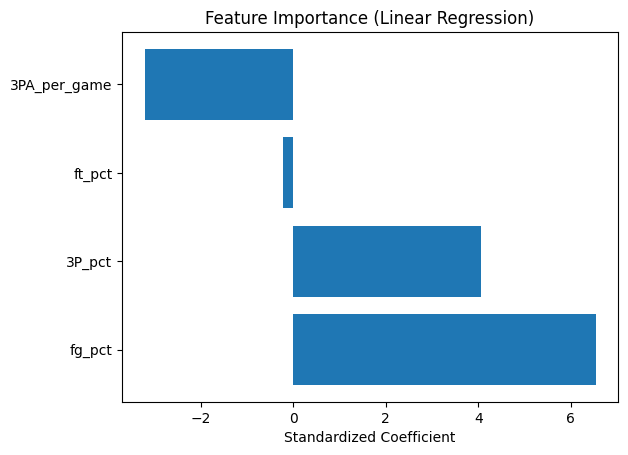

In [7]:
plt.figure()
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Standardized Coefficient")
plt.title("Feature Importance (Linear Regression)")
plt.show()

## Interpretation

Die standardisierten Koeffizienten zeigen den relativen Zusammenhang
zwischen den betrachteten Variablen und dem Teamerfolg.

Der Drei-Punkte-Wurf (Volumen und Effizienz) bleibt ein relevanter Faktor,
steht jedoch nicht isoliert, sondern wirkt im Zusammenspiel mit allgemeinen
Effizienzmaßen wie FG% und FT%.

## Fazit

Die Modellanalyse bestätigt, dass der Drei-Punkte-Wurf weiterhin
mit Teamerfolg zusammenhängt. Gleichzeitig zeigt sich, dass klassische
Effizienzkennzahlen ebenfalls eine wichtige Rolle spielen.

Das Modell dient als ergänzende Analyse und rundet die Untersuchung der
Three-Point Inflation ab.